In [2]:
## importing the required packages
import pandas
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import scanpy as sc
#import scikitplot as skplt # for roc curve 


In [66]:
##User Parameters
RUN_PCA = False
RUN_TSNE = False
SHOW_PLOT = False
WRITE_TO_FILE = False
n_neighbors = 30
n_iter = 700
#input_file_name = 'xab.csv'
input_file_name = 'GSE124061_MeA_AllCells_DGE.csv'
results_file = './write/smlgenes.txt.h5ad'  # the file that will store the analysis results

In [67]:
##Do not change anything below this
t = round(time())

## Loading and curating the data
digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

In [68]:
## Function to Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], ".",
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [69]:
"""
df = pandas.read_csv(input_file_name)

gene_ids = df.iloc[:,0]
df.index = gene_ids

cols = list(df.columns)[1:3266] # 3266
#cols = list(df.columns)
#gaba_names = ["Brs3",  "Greb1", "Fam84a", "Ankrd55", "Cck", "Nos1"]
#["Gal", "Esr1", "Vstm5", "Robo1", "Cbln2", "Cacna1c","Kcnip4", "Gpr75", "Gpr176","Galr1" ]
#sml_set = df.loc[gaba_names]
#X = sml_set.values
X = df.values
X = X[:, 1:3266] # 3266
X = np.transpose(X)
"""

'\ndf = pandas.read_csv(input_file_name)\n\ngene_ids = df.iloc[:,0]\ndf.index = gene_ids\n\ncols = list(df.columns)[1:3266] # 3266\n#cols = list(df.columns)\n#gaba_names = ["Brs3",  "Greb1", "Fam84a", "Ankrd55", "Cck", "Nos1"]\n#["Gal", "Esr1", "Vstm5", "Robo1", "Cbln2", "Cacna1c","Kcnip4", "Gpr75", "Gpr176","Galr1" ]\n#sml_set = df.loc[gaba_names]\n#X = sml_set.values\nX = df.values\nX = X[:, 1:3266] # 3266\nX = np.transpose(X)\n'

In [70]:
adata = sc.read_csv(input_file_name)
adata = sc.AnnData.transpose(adata) # full data set 43,388 rows 16,961 columns 

In [71]:
print(adata.shape)
#print(adata.X)
#adata = adata.X[:, 1:3266]

(43388, 16961)


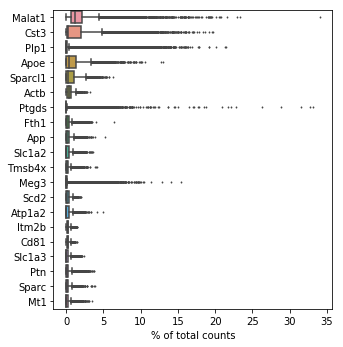

AnnData object with n_obs × n_vars = 24551 × 11334 
    obs: 'n_genes', 'louvain', 'n_counts'
    var: 'n_cells'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [80]:
# normalize and filter
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes=400)
sc.pp.filter_genes(adata, min_cells=400)

adata = adata[adata.obs['n_genes'] < 3000, :]

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)
adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4, copy=True)

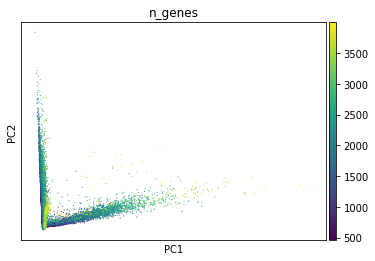

In [81]:
# pca
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='n_genes')

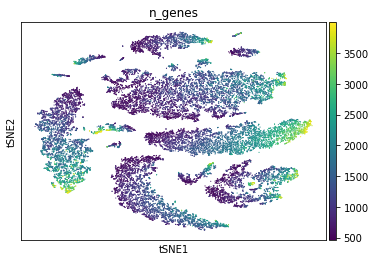

In [82]:
# tsne
ts_adata = sc.tl.tsne(adata)
sc.pl.tsne(adata, color='n_genes')

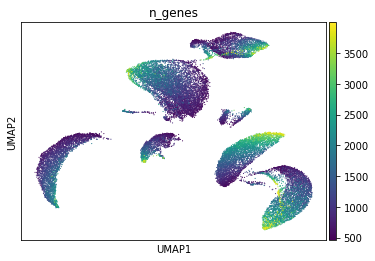

In [83]:
# umap
sc.pp.neighbors(adata, n_neighbors=1000, n_pcs=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color='n_genes')

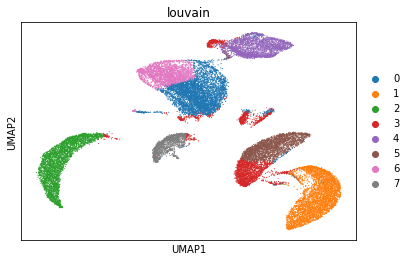

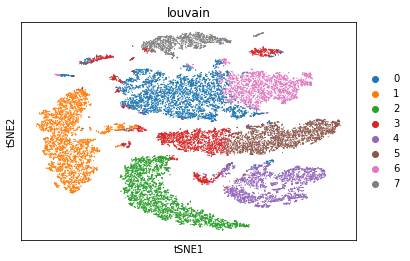

In [84]:
# louvain
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'], use_raw=False)
sc.pl.tsne(adata, color=['louvain'], use_raw=False)
adata.write(results_file)

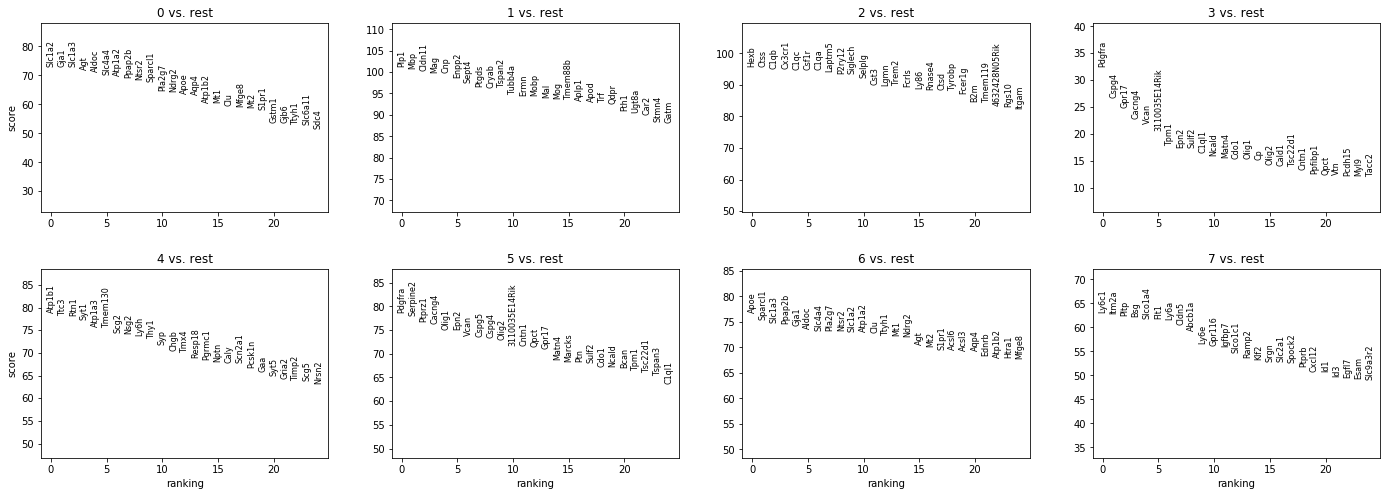

In [85]:
# finding marker genes 
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file)

In [3]:
pandas.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pandas.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

NameError: name 'adata' is not defined

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
new_cluster_names = [
    'Astrocyte', 'OPC-OL',
    'Microglia', 'Mural',
    'Neurons', 'OPC',
    'Oligo', 'Endothelial']
adata.rename_categories('louvain', new_cluster_names)

In [ ]:
# Export single fields of the annotation of observations
adata.obs[['n_genes', 'louvain']].to_csv('./write/xaa_run.csv')

In [ ]:
# Export single columns of the multidimensional annotation
adata.obsm.to_df()[['X_tsne1', 'X_tsne2']].to_csv('./write/sml_tsnedat.csv')

In [ ]:
filename = './write/sml_tsnedat.csv'
X = pandas.read_csv(filename)

In [ ]:
ids = X.iloc[:,0]
X.index = ids
X_vals = X.values[:, 1:]
print(X_vals)
X.head()

In [ ]:
# Using sklearn kmeans
km = KMeans(n_clusters=4)
km = km.fit(X_vals)
y_kmeans = km.predict(X_vals)

In [ ]:
plt.figure
plt.scatter(X_vals[:,0], X_vals[:,1], c=km.labels_, cmap='rainbow')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:, 1], c='black')
plt.show()

In [ ]:
#X = np.transpose(X)

if RUN_PCA:
    ## Computing PCA
    print("Computing PCA projection")
    t0 = time()
    X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
    tt_pca = round(time() - t0, 2)
    print("time taken by PCA:", tt_pca, "seconds")
    if SHOW_PLOT:
        print("generating PCA plot...")
        plot_title = "Principal Components projection (time %.2fs)" % (tt_pca)
        plot_embedding(X_pca, plot_title)


In [ ]:
if RUN_TSNE:
    ## Computing t-SNE
    print("Computing t-SNE with n_iter", n_iter)
    tsne = manifold.TSNE(init='pca', random_state=0, n_iter=n_iter)
    # tsne = manifold.TSNE()
    t0 = time()
    print("Transformation..")
    X_tsne = tsne.fit_transform(X)
    tt_tsne = round(time() - t0, 2)
    print("time taken by tSNE:", tt_tsne, "seconds")
    if SHOW_PLOT:
        print("generating t-SNE plot...")
        plot_title = "t-SNE (n_iter %d)(time %.2fs)" % (n_iter, tt_tsne)
        plot_embedding(X_tsne, plot_title)

In [ ]:
if WRITE_TO_FILE:
    print("writing results to file")
    if RUN_PCA or RUN_TSNE:
        cols_t = np.array([cols])
        if RUN_TSNE:
            tsne_filename = 'tsne_' + str(t) + '.txt'
            print("writing tSNE results to file named", tsne_filename)
            X_tsne_2 = np.concatenate((cols_t.T, X_tsne), axis=1)
            np.savetxt(tsne_filename, X_tsne_2, delimiter="\t", fmt='%s')
        if RUN_PCA:
            pca_filename = 'pca_' + str(t) + '.txt'
            print("writing PCA results to file named", pca_filename)
            X_pca_2 = np.concatenate((cols_t.T, X_pca), axis=1)
            np.savetxt(pca_filename, X_pca_2, delimiter="\t", fmt='%s')

In [ ]:
if SHOW_PLOT:
    print("displaing plots now ..")
    plt.show()